# Tidal melting analysis
Import tidal analysis routine and load roms data (30 days of hourly melt rates).

In [1]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

from features.grid_ttide import grid_ttide
%aimport features.grid_ttide

In [2]:
his_path = os.path.join(os.environ.get('rawdir'),'waom10','ocean_his_hourly_0007.nc')
rds = xr.open_dataset(his_path,chunks={'xi_rho':100,'eta_rho':100})
his_path = os.path.join(os.environ.get('rawdir'),'waom10_no_tides','ocean_his_hourly_0007.nc')
rds_nt = xr.open_dataset(his_path,chunks={'xi_rho':100,'eta_rho':100}).sel(ocean_time=rds.ocean_time)

In [3]:
print('start stop\n tides: ',rds.ocean_time.values[[0,-1]],'\n no_tides: ',rds_nt.ocean_time.values[[0,-1]])
print('sample length in days: ',rds.ocean_time.size/24)

start stop
 tides:  ['2000-12-30T01:00:00.000000000' '2001-03-04T11:00:00.000000000'] 
 no_tides:  ['2000-12-30T01:00:00.000000000' '2001-03-04T11:00:00.000000000']
sample length in days:  64.45833333333333


Select single ice shelf (FRIS) for testing.

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


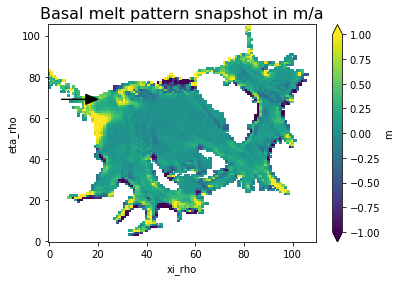

In [4]:
s2a = 3600*24*365

FRIS = rds.isel(xi_rho = slice(270,380),eta_rho = slice(380,486))
FRIS['m'] *= s2a

FRIS_nt = rds_nt.isel(xi_rho = slice(270,380),eta_rho = slice(380,486))
FRIS_nt['m'] *= s2a

plt.close()
FRIS.where((FRIS.mask_rho==1) & (FRIS.zice<0.0)).m[0].plot(vmin=-1,vmax=1)
plt.title('Basal melt pattern snapshot in m/a',fontsize=16)
ax = plt.axes()
ax.arrow(5, 69, 10, 0.0, head_width=5, head_length=5, fc='k', ec='k')
plt.show()

## Analysis of single cell melt signal from the ice shelf front

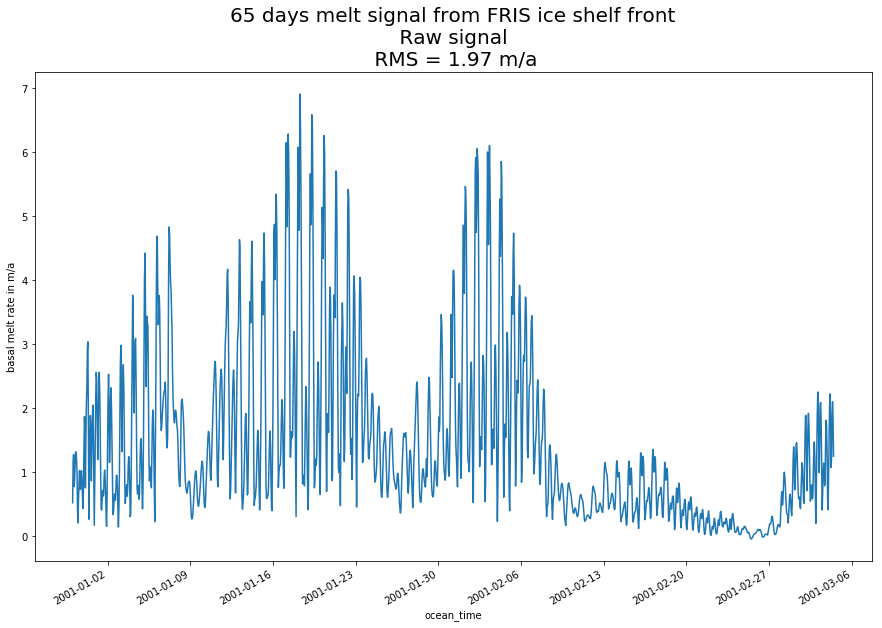

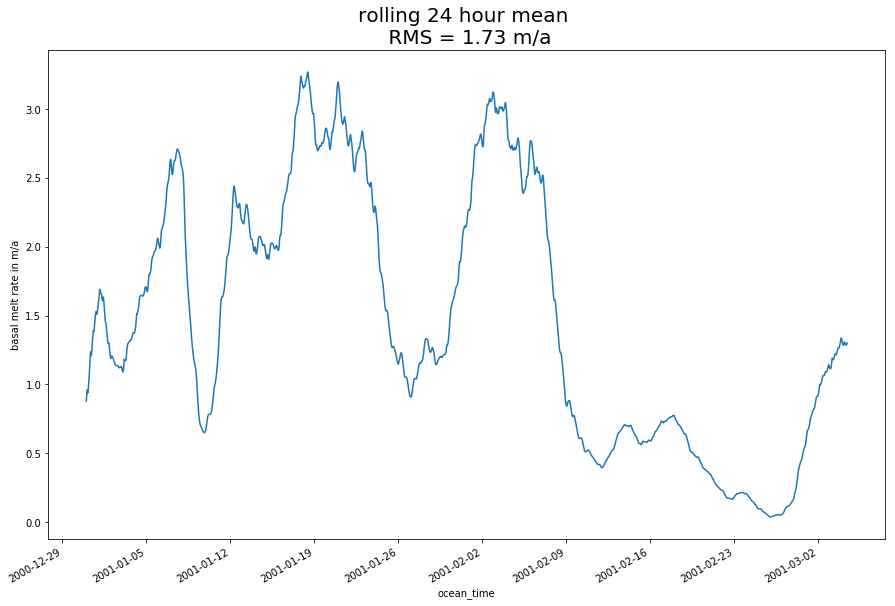

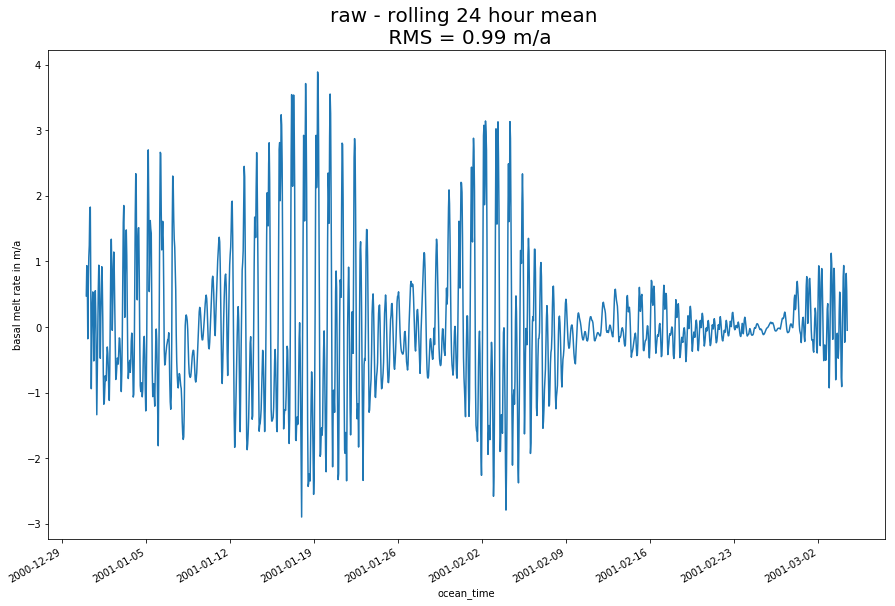

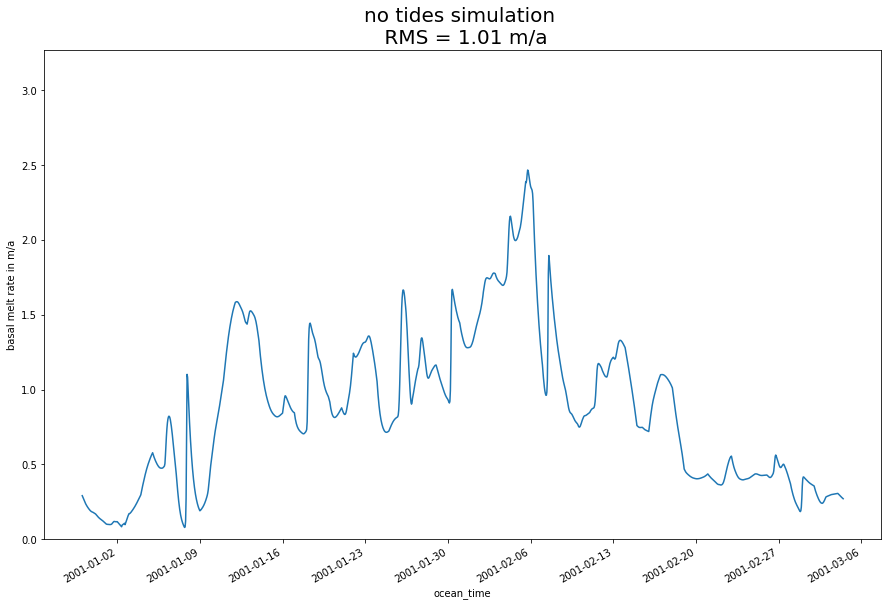

In [5]:
signal = FRIS.isel(eta_rho=69,xi_rho=15).m
signal_nt = FRIS_nt.isel(eta_rho=69,xi_rho=15).m

daily_rolling_mean = signal.rolling(ocean_time=24).mean()
direct_tidal_melt = signal - daily_rolling_mean

plt.close()

signal.plot(size=10)
plt.title("65 days melt signal from FRIS ice shelf front\n Raw signal \n RMS = %.2f m/a"%np.sqrt((signal**2).mean()),fontsize=20)
plt.ylabel('basal melt rate in m/a')

daily_rolling_mean.plot(size=10)
plt.title("rolling 24 hour mean \n RMS = %.2f m/a"%np.sqrt((daily_rolling_mean**2).mean()),fontsize=20)
plt.ylabel('basal melt rate in m/a')

direct_tidal_melt.plot(size=10)
plt.title("raw - rolling 24 hour mean \n RMS = %.2f m/a"%np.sqrt((direct_tidal_melt**2).mean()),fontsize=20)
plt.ylabel('basal melt rate in m/a')

signal_nt.plot(size=10)
plt.title("no tides simulation \n RMS = %.2f m/a"%np.sqrt((signal_nt**2).mean()),fontsize=20)
plt.ylabel('basal melt rate in m/a')
plt.ylim([0,daily_rolling_mean.max().values])

plt.show()

FFT to get power spectrum. will inform you which filter to apply. slope of powerspectrum says something about how energy is transferred within the frequencies. 

Samples:  1547  sampling period in h:  1.0


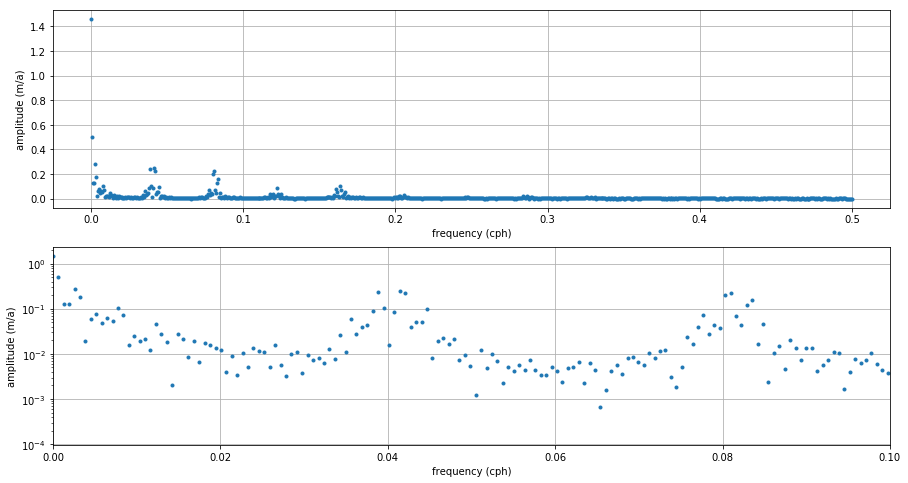

In [6]:
from scipy.fftpack import fft

# Number of sample points
N = signal.ocean_time.size
# sample spacing is 1h
T = 1.0
print('Samples: ',N," sampling period in h: ",T)
y = signal.values
yf = fft(y)
# you can look at frequencies that are maximal half of the sampling frequency 
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig,axes = plt.subplots(2,figsize=(15,8))
ax1,ax2 = axes.flatten()
ax1.plot(xf, 1.0/N * np.abs(yf[0:N//2]),'.')

ax2.semilogy(xf, 1.0/N * np.abs(yf[0:N//2]),'.')
ax2.set_xlim(0,0.1)

for ax in axes:
    ax.grid()
    ax.set_ylabel('amplitude (m/a)')
    ax.set_xlabel('frequency (cph)')
plt.show()

In [7]:
import ttide as tt
import pandas as pd
stime=pd.to_datetime(signal.ocean_time[0].values)
lat=signal.lat_rho.values
print(stime,lat)
tt_out = tt.t_tide(signal.values,stime=stime,lat=lat)

2000-12-30 01:00:00 -74.9228967272284
-----------------------------------
nobs = 1547 
ngood = 1547 
record length (days) = 64.46
start time: 2000-12-30 00:59:59
rayleigh criterion = 1.0

Greenwich phase computed with nodal
                   corrections applied to amplitude
                   and phase relative to center time

x0= 1.46  xtrend= 0
var(data)= 1.74    var(prediction)= 0.55    var(residual)= 1.24
var(prediction)/var(data) (%) = 31.7

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
  MM    0.0015122     0.4021     0.695     12.26    119.41      0.33
  MSF   0.0028219     0.6431     0.794    244.59     77.07      0.66
  ALP1  0.0343966     0.0427     0.197    346.38    189.87     0.047
  2Q1   0.0357064     0.1270     0.223    305.63    115.86      0.33
  Q1    0.0372185     0.1051     0.205    240.40    145.88      0.26
* O1    0.0387307     0.4636     0.246    229.09     39.66       3.6
  NO1   0.0

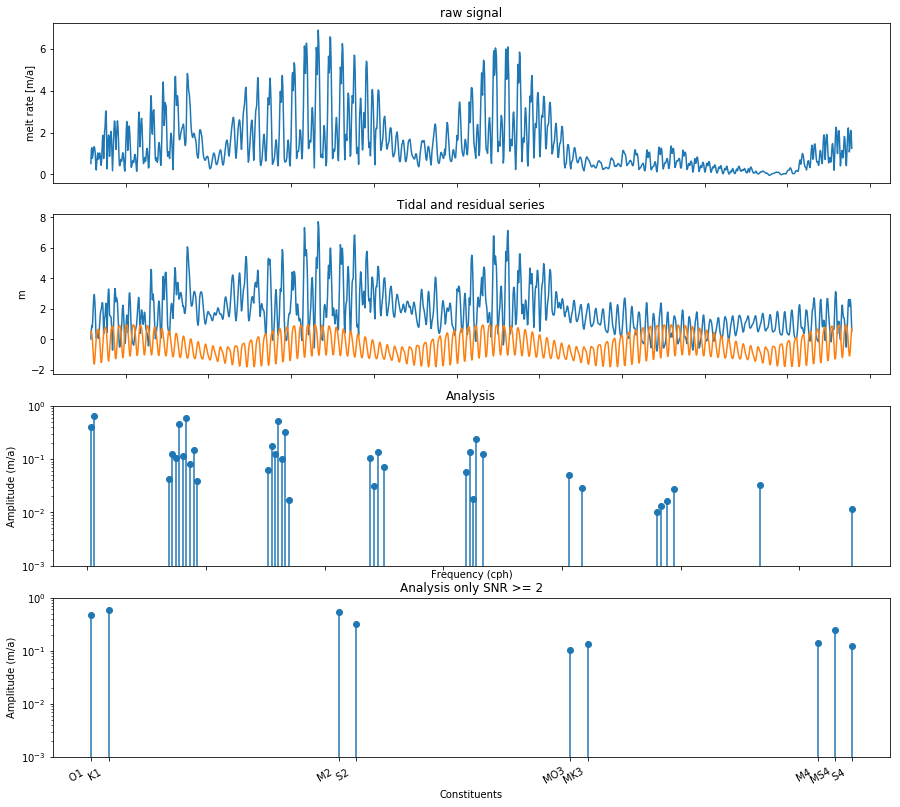

In [105]:
plt.close()
fig,axes = plt.subplots(nrows=4,figsize=(15,15))
ax1,ax2,ax3,ax4 = axes.flatten()

signal.plot(ax=ax1)
ax1.set_title('raw signal')
ax1.set_ylabel('melt rate [m/a]')

t_pred = tt_out(np.arange(signal.ocean_time.size))
(signal-t_pred).plot(ax=ax2)
ax2.plot(signal.ocean_time.values,t_pred)
ax2.set_title('Tidal and residual series')

x=tt_out['fu']
y=tt_out['tidecon'][:,0]
ax3.stem(x,y,bottom=0.0001)
ax3.set_title('Analysis')
ax3.set_yscale('log')
ax3.set_ylim(0.001,1)
ax3.set_xlabel('Frequency (cph)')
ax3.set_ylabel('Amplitude (m/a)')

strong = (tt_out['snr']>=2.0)
ax4.stem(x[strong],y[strong],bottom=0.0001)
ax4.set_title('Analysis only SNR >= 2')
ax4.set_yscale('log')
ax4.set_ylim(0.001,1)
ax4.set_xticks(x[strong])
ax4.set_xticklabels(tt_out['nameu'][strong].astype(str))
ax4.set_xlabel('Constituents')
ax4.set_ylabel('Amplitude (m/a)')

plt.show()

fig.tight_layout()

plt.show()

## Analysis of full ice shelf

In [9]:
map_raw = FRIS.m
map_nt = FRIS_nt.m
map_daily_rolling_mean = map_raw.rolling(ocean_time=24).mean()
map_direct_tidal_melt = map_raw - map_daily_rolling_mean

map_total_tidal_melt_avg = map_raw.mean('ocean_time') - map_nt.mean('ocean_time')

map_direct_tidal_melt_avg = map_direct_tidal_melt.mean('ocean_time')
map_direct_tidal_melt_std = map_direct_tidal_melt.std('ocean_time')

map_indirect_tidal_melt = map_daily_rolling_mean.mean('ocean_time') - map_nt.mean('ocean_time')

KeyboardInterrupt: 

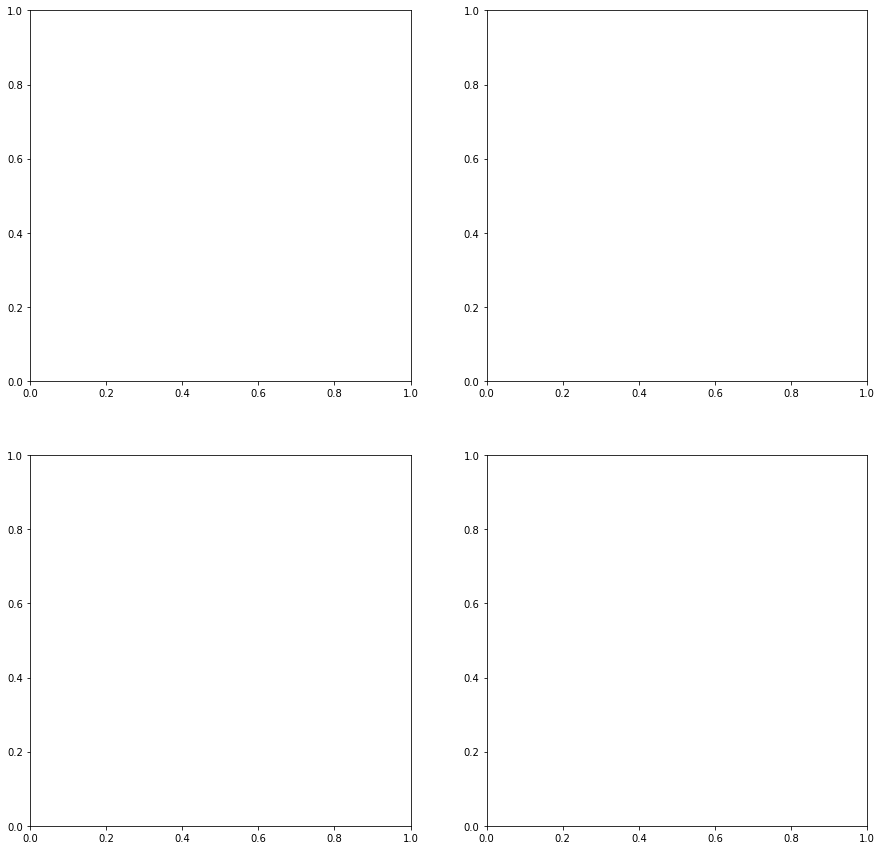

In [10]:
plt.close()
fig,axes = plt.subplots(2,2,figsize=(15,15))
(ax0,ax1,ax2,ax3) = axes.flatten()

map_total_tidal_melt_avg.plot(ax=ax0)
ax0.set_title('total tidal melt avg [m/a] (raw avg - no tides avg)\n (area avg = %.3e m/a)'%map_total_tidal_melt_avg.mean(),fontsize=16)

map_direct_tidal_melt_avg.plot(ax=ax1)
ax1.set_title("direct tidal melt avg [m/a] (raw avg - daily mean avg)\n (area avg = %.3e m/a)"%map_direct_tidal_melt.mean(),fontsize=16)

map_direct_tidal_melt_std.plot(ax=ax2)
ax2.set_title("direct tidal melt STD [m/a] (raw avg - daily mean avg)",fontsize=16)

map_indirect_tidal_melt.plot(ax=ax3)
ax3.set_title('indirect tidal melt avg [m/a] (daily mean avg - no tides avg)\n (area avg = %.3e m/a)'%map_indirect_tidal_melt.mean(),fontsize=16)


for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.show()

In [ ]:
tt_out_shelf = grid_ttide(map_raw.where((FRIS.mask_rho==1) & (FRIS.zice<0.0)),FRIS,res=30,constit_list=['O1','M2','K1','S2'])

In [ ]:
plt.close()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Tidal analysis of FRIS',fontsize=20)
tt_out_shelf.where((FRIS.mask_rho==1) & (FRIS.zice<0.0)).M2_amp.plot(ax=ax1)
ax1.set_title('M2 amplitude of raw melt signal [m/a]',fontsize=16)
tt_out_shelf.where((FRIS.mask_rho==1) & (FRIS.zice<0.0)).O1_amp.plot(ax=ax2)
ax2.set_title('O1 amplitude of raw melt signal [m/a]',fontsize=16)

for ax in [ax1,ax2]:
    ax.set_aspect('equal')
    ax.axis('off')
plt.show()